In [4]:
library("TSP")
concorde_path("~/concorde/TSP")
source("functions.R")




dataETSP <- read_TSPLIB("/home/LC/mailo01/TSP-ML-Approach/src/Official_Cases/zi929.tsp")


found: concorde concorde.c concorde.o 


In [3]:
start_time <- Sys.time()
dataTSP <- as.TSP(dataETSP)
concorde_tour<- solve_TSP(dataTSP, method="concorde")
end_time <- Sys.time()
concorde_time <- end_time - start_time
concorde_result <- tour_length(concorde_tour,dataETSP)
print("processing time")
concorde_time
print("tour_length")
concorde_result

plot(dataETSP, concorde_tour)

ERROR: Error in as.TSP(dataETSP): object 'dataETSP' not found


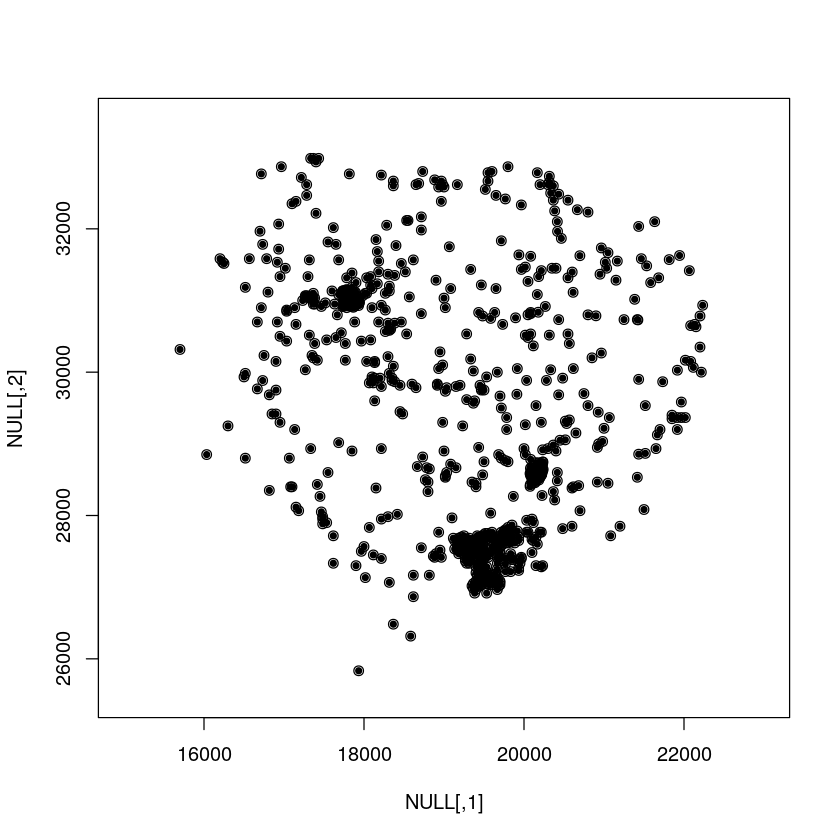

In [7]:
library("hash")
library("sets")

pointSet <- hash()
noPts <- length(dataETSP)/2
horizontal_based <- list()
vertical_based <-list()

radius <- 60
plot(dataETSP,xlim=c(15000,23000), ylim=c(25500,33500), pch=20)
symbols(dataETSP, circles=rep(radius,noPts), add=T, inches=F)

In [8]:
#main program

#terminology:
#neighborhood = cluster = branch
#current_tree = "the set of all neighborhoods" (a list of lists)

print("preparing necessary data")
start_time <- Sys.time()
for (i in 1:noPts){
    pointSet[[toString(i)]] <- tuple(dataETSP[i], dataETSP[i+noPts])
    element <- list(i, dataETSP[[i]],dataETSP[[i+noPts]])
    horizontal_based <- append( horizontal_based, list(element))
    vertical_based <- append(vertical_based, list(element))
}
#sorting the points in term of x and y axis. This step speeds up the process of identifying neighbors by only checking the candidates in the box instead of every points possible.
#the box is a 2*r by 2*r square that has the center at the point we are considering. 
horizontal_based <- horizontal_based[order(sapply(horizontal_based, '[[', 2))]
vertical_based <- vertical_based[order(sapply(vertical_based,'[[',3))]
vertices_mat <- as.matrix(as.TSP(dataETSP))
checklist <-(c(1:noPts))
end_time <-Sys.time()
print("total time to pre process data")
add<- end_time - start_time
total<-  add
print(add)

#identify neighborhoods
print("begin identifying neighborhoods based on given radius")
start_time <- Sys.time()
current_tree <- identify_neighborhood(checklist, pointSet,horizontal_based, vertical_based)
end_time <- Sys.time()

print("finished finding neighborhoods. Total processing time: ")
add<- end_time - start_time
total<- total + add
print(add)

#Concorde Solver will not solve instance with 2 points. Needs implementation for 2pt scenario
branch_no <- length(current_tree)
print("total number of neighborhood")
print(branch_no)
if (branch_no <= 2){
    print("number of neighborhoods smaller or equal 2. Concorde Solver will halt")
    cont <- FALSE
} else {
    print("generating neighborhoods' TSP instance")
    print("this step needs improvement since it usually takes 90+% of processing time")
    start_time <- Sys.time()
    cluster_mat <- matrix(rep(0,branch_no^2),nrow=branch_no)

    #generating distance matrix and storing information of endpoints in each neighborhood
    connections <- hash()

    for (branch_index in 1:branch_no){
        #other branches to be compared to
            for (branch_compare_ind in 1:length(current_tree)){
                if (has.key(sprintf("%s-%s",branch_index,branch_compare_ind),connections) == FALSE){

                if (branch_index != branch_compare_ind){
                    minimum_dist <- Inf
                    connect_pts <- NULL

                    for (vertex in current_tree[[branch_index]]){
                        
                        for (vertex_compare in current_tree[[branch_compare_ind]]){
                            if (minimum_dist == Inf){
                                minimum_dist <- vertices_mat[vertex, vertex_compare]
                                connect_pts <- list(vertex, vertex_compare)
                            } else{
                                distance <- vertices_mat[vertex, vertex_compare]
                                if (distance <= minimum_dist){
                                    minimum_dist <- distance
                                    connect_pts <- list(vertex, vertex_compare)
                                } 
                            }
                        } 
                    }

                    connections[[sprintf("%s-%s",branch_index,branch_compare_ind)]] <-  tuple(connect_pts[[1]],connect_pts[[2]])
                    connections[[sprintf("%s-%s",branch_compare_ind,branch_index)]] <-  tuple(connect_pts[[2]],connect_pts[[1]])
                    #append distances to matrix
                    cluster_mat[branch_index,branch_compare_ind] <- minimum_dist
                    cluster_mat[branch_compare_ind,branch_index] <- minimum_dist


                }
            }
        }
    }
    
    
    tsp_cluster <- as.TSP(cluster_mat)
    end_time <- Sys.time()
    
    print("neighborhoods' TSP generated. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    #solving neighborhood tour
    print("solving the neighborhood's TSP")
    start_time <- Sys.time()
    cluster_tour <- solve_TSP(tsp_cluster, method="concorde")
    end_time <- Sys.time()
    print("solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    #choosing non conflicting end points
    print("choosing suitable endpoints")
    start_time <- Sys.time()
    end_points_list<- end_points_det(cluster_tour, connections)
    end_time <- Sys.time()
    print("determined. total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    # solving tour for each neighborhood with corresponding end points
    print("solving for each neighborhood's tour")
    start_time <- Sys.time()

    all_solutions <- list()
    for (branchNo in 1:length(current_tree)){
        print("subcase")
        print(branchNo)
        pts  <- data.frame(x=c(), y=c())
        if ( length(current_tree[[branchNo]]) <=2){
            print("trivial. number of points smaller or equal 2")
            if (length(current_tree[[branchNo]]) == 1){

                all_solutions <- append(all_solutions, list(list(1)))
            }

            if (length(current_tree[[branchNo]]) == 2){
                all_solutions <- append(all_solutions, list(list(2,1)))
            }

        }else{
            
            end_points <- end_points_list[[toString(branchNo)]]
            end_points_pos <-list()
            
            print("generating TSP instance for sub case")
            for (pt in current_tree[[branchNo]]){
                if (pt %in% end_points){
                    end_points_pos <- append(end_points_pos, match(pt,current_tree[[branchNo]] ))
                }
                pt_data <- values(pointSet, keys=pt)
                pts <- rbind(pts, c(pt_data[[1]],pt_data[2]))           

            }
            tsp_subcase <- TSP(dist(pts))
            end_points <- end_points_list[[toString(branchNo)]]
            
            
            tsp_subcase <- add_end_points(tsp_subcase, end_points_pos)

            
            print("using concorde solver.")
            cont <- TRUE
            while (cont == TRUE){
                tour <-  solve_TSP(tsp_subcase)
                if (tour_length(tour, tsp_subcase) != Inf){
                    cont <- FALSE
                }
            }
            print("done. append the current solution")

            all_solutions <- append(all_solutions, list(as.list(as.integer(tour))))
        }
    }
    end_time <- Sys.time()
    print("all individual neighborhood's tour are solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    #merging tours in each neighborhoods according to neighborhood tour
    print("merging") 
    start_time <- Sys.time()
    to_global_subtours <- to_global(all_solutions, current_tree)
    all_subtours <- filter_before_merge(to_global_subtours,end_points_list)
    merged_tour <-merge_all(all_subtours, cluster_tour)
    end_time <- Sys.time()
    add<- end_time - start_time
    total<- total + add
    print(add)
    print("process ends. Total time")
    print(total)
}



[1] "preparing necessary data"
[1] "total time to pre process data"
Time difference of 0.166512 secs
[1] "begin identifying neighborhoods based on given radius"
[1] "finished finding neighborhoods. Total processing time: "
Time difference of 3.610133 secs
[1] "total number of neighborhood"
[1] 273
[1] "generating neighborhoods' TSP instance"
[1] "this step needs improvement since it usually takes 90+% of processing time"
[1] "neighborhoods' TSP generated. Total processing time"
Time difference of 8.633638 secs
[1] "solving the neighborhood's TSP"
Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


[1] "solved. Total processing time"
Time difference of 6.7875 secs
[1] "choosing suitable endpoints"
[1] "determined. total processing time"
Time difference of 0.09739757 secs
[1] "solving for each neighborhood's tour"
[1] "subcase"
[1] 1
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 2
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 3
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 4
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 5
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 6
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 7
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 8
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 9
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 10
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 11
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 12
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 13
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 14
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 15
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 16
[1] "trivial. number of points smaller or equal 2"
[

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 33
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 34
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 35
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 36
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 37
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 38
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 39
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 40
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [164] is not a sub-multiple or multiple of the number of columns [165]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 41
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 42
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 43
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 44
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 45
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 46
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 47
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 48
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 49
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 50
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 51
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 52
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 53
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 54
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 55
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 56
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 57
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 58
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 59
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 60
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 61
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 62
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 63
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 64
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 65
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 66
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 67
[1] "trivial. number of points smaller or equa

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 77
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 78
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 79
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 80
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 81
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 82
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 83
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 84
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 85
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 86
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 87
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 88
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 89
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 90
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 91
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 92
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 93
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 94
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 95
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 96
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 97
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 98
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 99
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 100
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 101
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 102
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 103
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 104
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 105
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 106
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 107
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 108
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 109
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 110
[1] "trivial. number of points smal

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 115
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 116
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 117
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 118
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 119
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 120
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 121
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 122
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 123
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 124
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 125
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 126
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 127
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 128
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 129
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 130
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 131
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 132
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 133
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 134
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 135
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 136
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 137
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 138
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 139
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 140
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 141
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 142
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [203] is not a sub-multiple or multiple of the number of columns [204]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 143
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 144
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 145
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 146
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 147
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 148
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 149
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 150
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 151
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 152
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 153
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 154
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 155
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 156
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 157
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 158
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 159
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 160
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 161
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 162
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 163
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 164
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 165
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 166
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 167
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 168
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 169
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 170
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 171
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 172
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 173
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 174
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 175
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 176
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 177
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 178
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [152] is not a sub-multiple or multiple of the number of columns [153]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 182
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 183
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 184
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 185
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 186
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 187
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 188
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 189
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 190
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 191
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 192
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 193
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 194
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 195
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 196
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 197
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 198
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 199
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 200
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 201
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 202
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 203
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 204
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 205
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 206
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 207
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 208
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 209
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 210
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 211
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 212
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 214
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 215
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 216
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 217
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 218
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 219
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 220
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 221
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 222
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 223
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 224
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 225
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 226
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 227
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 228
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 229
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 230
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 231
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 232
[1] "generating TSP instance for 

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 233
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 234
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 235
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 236
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 237
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 238
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 239
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 240
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 241
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 242
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 243
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 244
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 245
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 246
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 247
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 263
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 264
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 265
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 266
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 267
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 268
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 269
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 270
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 271
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 272
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 273
[1] "trivial. number of points smaller or equal 2"
[1] "all individual neighborhood's tour are solved. Total processing time"
Time difference of 0.5956481 secs
[1] "merging"
  [1]   1   9   7  17  12  26  23  24  25  32  44  40  63 100 201 285 275 314
 [19] 293 284 260 254 251 269 283 334 346 347 358 349 356 353 376 529 611 805
 [37] 831 827 836 835 855 858 862 871 882 872 874 878 879 884 873 866 865 839
 [55] 818 824 845 859 869 876 853 849 840 821 647 631 637 688 617 633 614 571
 [73] 575 593 592 630 730 796 847 852 848 860 846 842 828 833 819 812 814 815
 [91] 813 803 788 766 784 804 789 793 791 808 816 806 807 777 771 759 753 769
[109] 775 787 798 809 810 792 799 802 800 801 79

[1] "evaluation of result: "
[1] "the ratio of this heuristics result over concorde result is: "


[1] 1.022243

[1] "the absolute value of the difference between 2 results"


[1] 2120.748

[1] "the time it takes for the heuristic method is "


Time difference of 126.2236 secs

[1] "the time it takes for the concorde solver is "


Time difference of 1.43474 mins

[1] "this is the plot of the heuristic produced tour: "


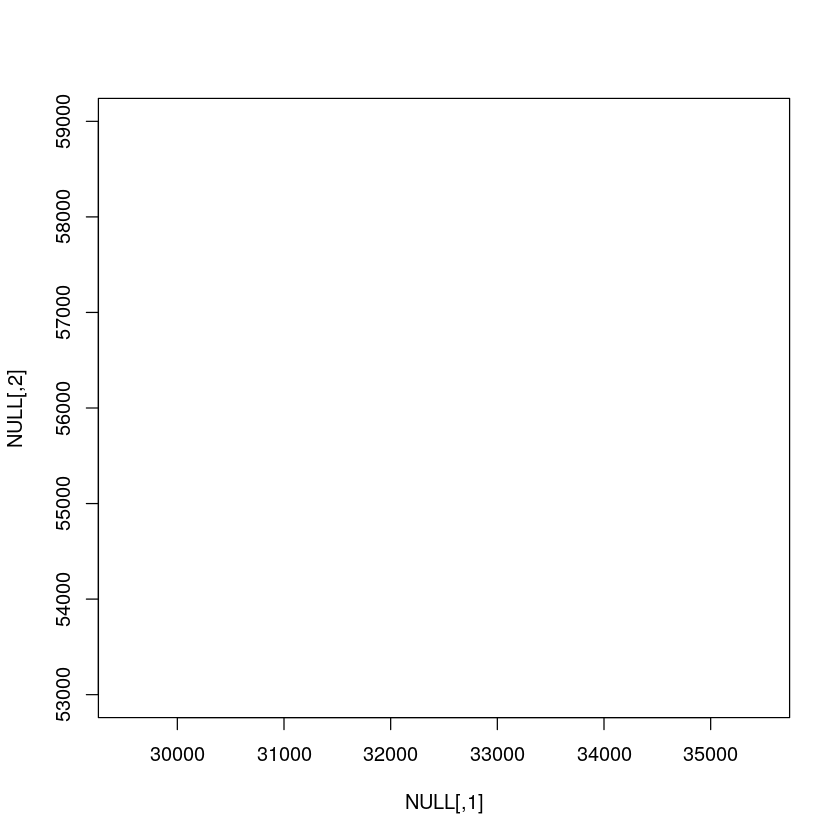

In [56]:
print("evaluation of result: ")
print("the ratio of this heuristics result over concorde result is: ")
tour_length(as.TOUR(merged_tour),dataETSP)/concorde_result

print("the absolute value of the difference between 2 results")
tour_length(as.TOUR(merged_tour),dataETSP) - concorde_result

print("the time it takes for the heuristic method is ")
total
print("the time it takes for the concorde solver is ")
concorde_time

print("this is the plot of the heuristic produced tour: ")
plot(dataETSP, as.TOUR(merged_tour),xlim=c(29500,35500), ylim=c(53000,59000))